 # From One to Many Challenge - Starter Notebook

 Challenge link: https://xeek.ai/challenges/from-one-to-many


## Background

The algorithm and challenge idea behind "From One to Many" comes from research done by McAliley and Li (2021) to explore the nonuniqueness of gravity fields.

Gravitation interpretation is the process of inferring the subsurface structure of the earth by analyzing the gravity field.  This is typically done by measuring the variations in the earth's gravity field using instruments such as gravimeters.  Many factors can contribute to variations in the gravity field, such as variations in rock density, topography, and geologic structure.  Therefore, interpreting the resulting gravity signals can be complex since many subsurface configurations can produce the same signal.

Using machine learning techniques can help us to explore how the diversity of subsurface configurations gives rise to similar gravity fields.  For example, generative models, such as (conditional) variational autoencoders, (C)VAEs, can be trained to generate synthetic gravity fields that are similar to real-world gravity fields. 

For this challenge, we will simplify the problem by modeling a signal as a function of two vectors with the given requirements.

## The Statement of the Problem

Let's assume we have given signal Y, which we know is some custom function (for example as the product) of the vectors X0 (decreasing straight line) and X1 (increasing straight line).  Can we generate a complete solution space of combination (X0, X1) producing the same given signal Y?

We suggest performing the training process with a conditional variational autoencoder (CVAE) using the given architecture described below.  The CVAE is prepared to encode the input signals X0, X1, and Y into a lower-dimensional latent space and to generate diverse combinations (with the greatest possible diversity) of X0 and X1 that can produce similar signals Y. 

The goal of this challenge is to **customize provided NN architecture and find the optimal values for hyperparameters** to achieve **the mostly complete space of reconstructed X0/X1**.  Remember that X0/X1 should be as close to a straight line as possible, and reconstructed Y should be close to Y given. 


             

## The architecture of the given CVAE   


The provided architecture is designed as a conditional variational autoencoder (CVAE), including three main components: the Encoder, the Sampling (to perform reparametrization trick), and the Decoder.  Pay attention that the input tensor is concatenated pairs x0 & x1, which passed through the Encoder, and the Decoder is conditioned on the target Y, considered a continuous label.

Below you can see more detailed specifications of CVAE with enlisted layers of each component.  We invite participants to customize the parameters of this implementation (i.e., input/output sizes) as well as types and amounts of hidden layers, **but preserve interactions of the main components**.  

To provide more convenient playing with parameters of given layers, you can see all of them in the model_parameters dictionary, which is further stored as config_model.yaml and used during the initialization of the model.  To change the amount and type of layers, you could edit the src/CVAE_architecture.py module.  Please pay attention the functionality to quick start (like train, test, dataset class etc.) provided separately in src/CVAE_function.py module. 

In particular, the following hyperparameters are supposed to be tuned:

 - learning_rate: the learning rate for the optimizer used during training
 - batch_size: the batch size used during training
 - beta:  regularization parameter for loss function
 - wx, wy: weigths for reconstruction losses for x, y respectively  
 - num_epochs: the number of epochs to train for
 - latent_space_dim: the dimensionality of the latent space used by the CVAE


## Evaluation

The primary objective of the challenge is to design a neural network (specifically a Conditional Variational Autoencoder or CVAE) capable of generating a diverse set of paired straight lines that yield the desired expected result of applying a custom function to each pair.
In order to evaluate the results, we will consider the following criteria:
- Straightness of Generated Pairs: It assesses how closely the generated pairs resemble straight lines.
- Function Result Accuracy: It examines how accurately the custom function applied to the generated pairs aligns with the expected given result.
- Coverage of Specified Area: The evaluation is mainly based on the extent to which the generated pairs cover the specified range [0, 1] with the spread maximized as possible, but it will only be assessed if both other criteria mentioned above are met.


## 0. Environment & settings

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset  

import torch.utils.data as data_utils


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import yaml

# Module with CVAE antares architecture
from src import CVAE_antares as antares 

#Module with all related CVAE functions: train, test, etc.
from src import CVAE_functions as CVAE_fn

# set random seeds
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# setup device cuda vs. cpu
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

## 1. Prepare Dataset
### 1.1. Load Dataset

In [2]:
data_root = './data/'
filename = "x0_x1_y" 

filename_dataset = f'{data_root}{filename}.pt'
filename_test_dataset = f'{data_root}{filename}_test.pt'

dataset = CVAE_fn.SignalDataset_v4(torch.load(filename_dataset))
dataset_test = CVAE_fn.SignalDataset_v4(torch.load(filename_test_dataset))

print(f"Train dataset is loaded successfully and has length: {len(dataset)}")
print(f"Test dataset is loaded successfully and has length: {len(dataset_test)}")

# create a PyTorch DataLoader from the dataset
dataloader = DataLoader(dataset, batch_size = 100, shuffle=True)

# create a PyTorch DataLoader from the dataset_test
test_loader = DataLoader(dataset_test, batch_size=10, shuffle=True)

Train dataset is loaded successfully and has length: 100000
Test dataset is loaded successfully and has length: 1000


### 1.2. Plot Random Samples

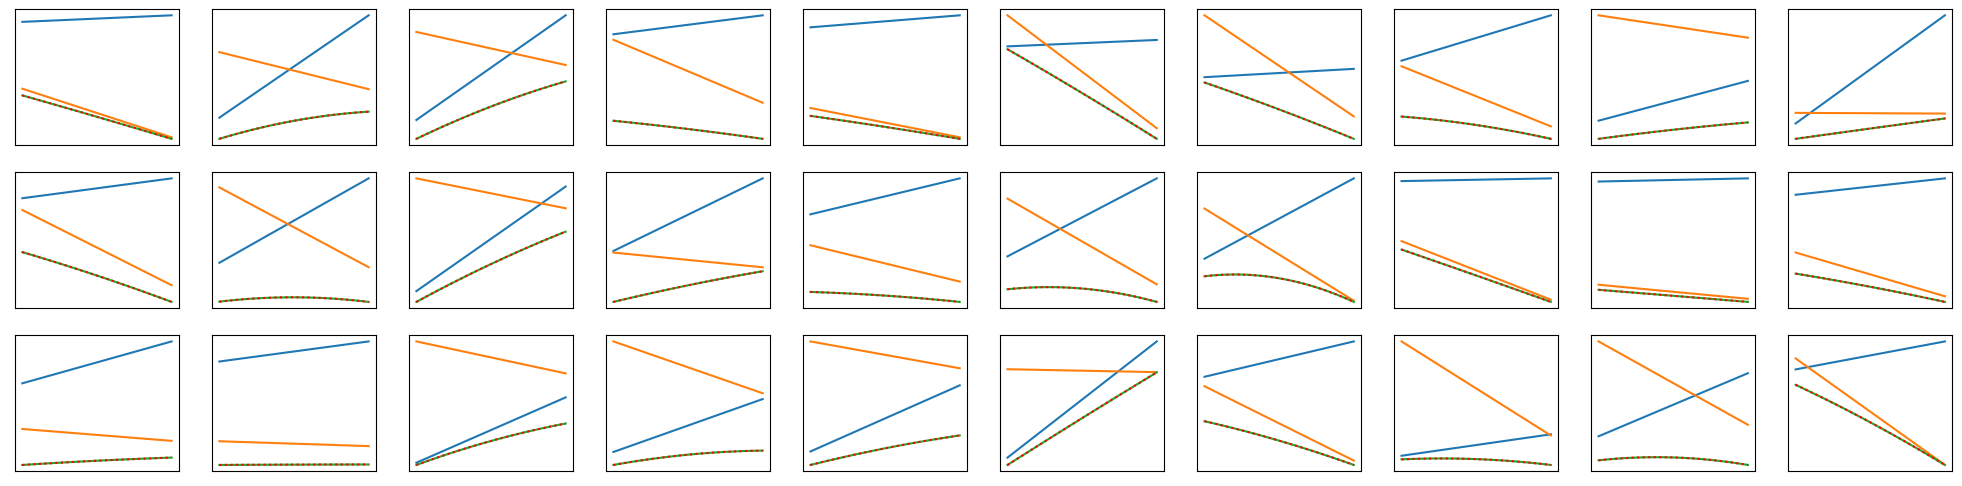

In [3]:
x,y = next(iter(dataloader))        

num_samples = 30

CVAE_fn.plot_samples(x, y, num_samples = num_samples)

In [4]:
# Customize your Model’s Architecture Based on next dictionary 

model_parameters = {
    "number_of_points": 50,
    "bias": True,
    "in_channels1": 1,
    "out_channels1": 32,
    "kernel_size1": [16, 2],
    "out_channels2": 64,
    "kernel_size2": [8, 1]
}

with open('src/config_model.yaml', 'w') as f:
    yaml.dump(model_parameters, f)
    
    
# Define the input dimensions
number_of_points = 50
input_shape = (1, number_of_points, 2)
cond_shape = (number_of_points,)



# Define initial state of hyperparameters
hyperparameters = {
    "latent_dim": 6,
    "lr" : 0.001,
    "batch_size" : 100,
    "beta" : 5,
    "wx": 0.02,
    "wy": 0.01,
    "num_epochs":10
}

latent_dim, lr, batch_size, beta, wx, wy, num_epochs = hyperparameters.values()
wx = wx * beta
wy = wy * beta

cvae = antares.CVAE(latent_dim).to(device)

# Define the model and optimizer
model = cvae
optimizer = optim.Adam(model.parameters(), lr = lr)

#Print model configuration
print("Current CVAE configuration: ")
model

Current CVAE configuration: 


CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(16, 2), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(8, 1), stride=(1, 1))
    (fc1_mean): Linear(in_features=1792, out_features=6, bias=True)
    (fc1_logvar): Linear(in_features=1792, out_features=6, bias=True)
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (fc1): Linear(in_features=56, out_features=1792, bias=True)
    (conv_transpose1): ConvTranspose2d(64, 32, kernel_size=(8, 1), stride=(1, 1))
    (conv_transpose2): ConvTranspose2d(32, 1, kernel_size=(16, 2), stride=(1, 1))
    (relu): ReLU()
  )
)

### 2.2. Generate samples from the untrained model

Generating samples from an untrained CVAE usually not produce high-quality  outputs since the model has not yet learned the underlying data distribution, but it could serve as a baseline for comparison. This comparison can help you evaluate the progress made during training, assess whether the model has learned meaningful representations, and understand how the quality of the generated samples has improved.

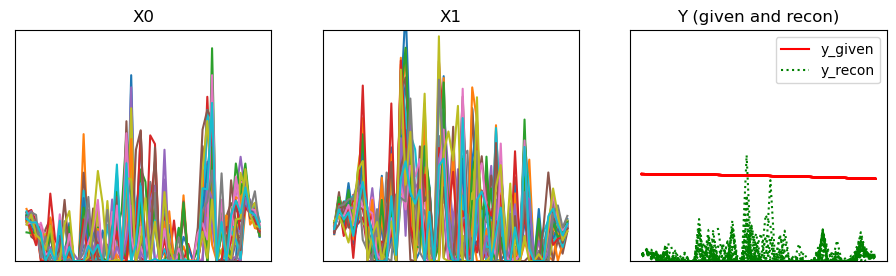

In [5]:
x_batch, y_batch = next(iter(dataloader))
y_idx = np.random.randint(batch_size)
given_y = y_batch[y_idx].unsqueeze(0).to(device) 


x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape, device)

CVAE_fn.plot_samples_stacked(x_output.cpu(), y_output.cpu())


### 2.3. Train & test model

In [6]:
for epoch in range(1, num_epochs + 1):
    CVAE_fn.train_cvae(model, dataloader, optimizer, beta, wx, wy, epoch, device)
    
CVAE_fn.test_cvae(model, test_loader,beta, wx, wy, device)

Train Epoch 1: Average Loss: 0.041004
Train Epoch 2: Average Loss: 0.010258
Train Epoch 3: Average Loss: 0.009795
Train Epoch 4: Average Loss: 0.009522
Train Epoch 5: Average Loss: 0.009360
Train Epoch 6: Average Loss: 0.009273
Train Epoch 7: Average Loss: 0.009192
Train Epoch 8: Average Loss: 0.009143
Train Epoch 9: Average Loss: 0.009115
Train Epoch 10: Average Loss: 0.009101
Test Loss: 0.009219


### 2.4. Hyperparameter's tuning process 

In [7]:
'''
YOUR CODE HERE

'''

'\nYOUR CODE HERE\n\n'

## 3. Sample generation of reconstructed X0/X1 pairs and saving results 

For submission **we recommend keep num_samples equals 30** for each given Y, in any cases for the Living scoring process will be used just 30 first samples. We don't limit how many given_Y you should use. The Live Scroing will be calculated as average of them. 

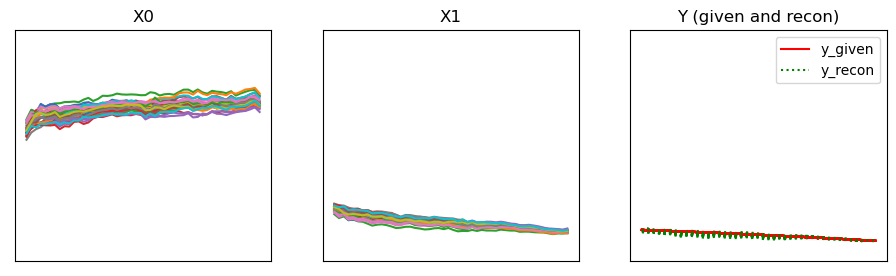

In [8]:
num_samples = 30 

x_batch, y_batch = next(iter(dataloader))

#for one random chosen one given_y
y_idx = np.random.randint(batch_size)

given_y = y_batch[y_idx].unsqueeze(0).to(device)

x_output, y_output = CVAE_fn.generate_samples(model, num_samples, given_y, input_shape, device)

CVAE_fn.plot_samples_stacked(x_output.cpu(), y_output.cpu())


In [9]:
#If you use several given_Y be sure that you concatanated generated samples x_output as well as y_output, i.e. next: 
    
'''
x_outputs = torch.cat([...], dim=0)   
y_outputs = torch.cat([...], dim=0) 
'''


# Save result as TensorDataset before submitting

ds = data_utils.TensorDataset(x_output,y_output)
torch.save(ds, 'result/result.pt') 

#Save tuned Hyperparameters 

'''
hyperparameters = {
    "latent_dim":  ,
    "lr" :   ,
    "batch_size" :   ,
    "beta" :  ,
    "wx":  ,
    "wy":  ,
    "num_epochs":
}
'''

with open('result/best_hyperparameters.yaml', 'w') as f:
    yaml.dump(hyperparameters, f)
 

## Submission and Evaluation

### Submission for LiveScoring 

Upload the results as **.pt** file with x_outputs/y_outputs generated by NN on http://xeek.ai/ to score your solution and update the leaderboard. 

The evaluation of the results will combine in a total score (highlighted on the LeaderBoarded) the following assessments:

 - Reconstruction error: This measures how close the vector Y_hat obtained from the generated X0_hat and X1_hat is to the given Y. A low reconstruction error indicates that the CVAE has learned to generate combinations of X0 and X1 that can produce similar signals Y. 
 
 - Preservation of the structure: This measures how well the vectors X0_hat and X1_hat have retained the given structure, which is straight lines with a preserved sign of slope. A high level of preservation indicates that the CVAE has learned to generate combinations of X0 and X1 that adhere to the given structure.

 - Diversity of generated combinations: This measures how well the CVAE has covered the solution space by generating diverse combinations of X0_hat and X1_hat that can produce similar signals Y. A high level of diversity indicates that the CVAE has generated a wide range of possible combinations of X0 and X1.

Please note that a **higher total score indicates a better solution**.

### Final Submission

Finalists will be invited to submit full solution as **ZIP** file for final review and scoring. 

This ZIP should include:
 - **.pt file** with x_outputs/y_outputs generated by NN.  
 - **best_hyperparameters.yaml** with hyperparameters tuned 
 - **model_parameters.yaml** as well as 
 - **CVAE_architecture.py** if any CVAE architecture changes were performed


## References

W. Anderson McAliley and Yaoguo Li, (2021), "Machine learning inversion of geophysical data by a conditional variational autoencoder," SEG Technical Program Expanded Abstracts : 1460-1464.